[*********************100%%**********************]  1 of 1 completed


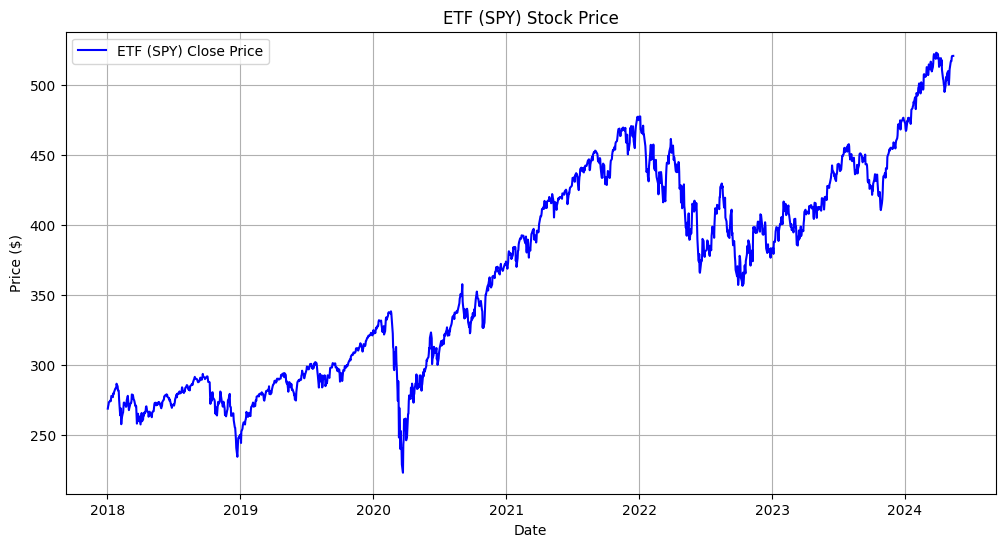

No data available for z-score computation.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Berry Cox price momentum factors
factors = {
    "Price Leading 12 Month Earnings (Weighted Avg of FVI and FY2)": lambda p: p["Close"].rolling(12).mean(),
    "Log of Market Capitalization": lambda p: np.log(p["MktCap"]),
    "Price Trailing 12 Month Sales": lambda p: p["Close"] / p["Sales TTM"],
    "Log of Stock Price": lambda p: np.log(p["Close"]),
    "Price Trailing 12 Month Cash Flow": lambda p: p["Close"] / p["Free Cash Flow TTM"],
    "Price Book Value": lambda p: p["Close"] / p["Book Value"],
    "Leading Dividend Yield": lambda p: p["Div Yield"],
    "Industry Relative Price/Trailing Sales (Current Spread vs. 5 Year Avg)": lambda p: (
        p["Close"] / p["Sales TTM"] - p["Close"].rolling(60).mean()
    ),
    "Accelerating 3 Month Momentum in Quarterly Sales": lambda p: (
        p["Sales"].rolling(3).mean() / p["Sales"].rolling(6).mean()
    ),
    # Add other factors as needed...
}

# Define ETF and historical data period
etf_symbol = "SPY"
start_date = datetime(2018, 1, 1)  # 5-year backtesting period
end_date = datetime.today()

# Download ETF data
data = yf.download(etf_symbol, start=start_date, end=end_date)

# Plot ETF data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='ETF (SPY) Close Price', color='blue')
plt.title('ETF (SPY) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate monthly z-scores for each factor
monthly_data = data.resample("ME").mean()  # Using 'ME' instead of 'M' to avoid FutureWarning

for col in monthly_data.columns:
    if col in factors:
        monthly_data[f"{col}_zscore"] = (monthly_data[col] - monthly_data[col].mean()) / monthly_data[col].std()

# Filter columns containing "_zscore" in their names
filtered_columns = monthly_data.filter(like="_zscore").columns

if not filtered_columns.empty:
    # Plot factor z-scores
    plt.figure(figsize=(12, 6))
    for col in filtered_columns:
        plt.plot(monthly_data.index, monthly_data[col], label=col)

    plt.title('Factor Z-Scores')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for z-score computation.")


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define Berry Cox price momentum factors
factors = {
    "Price Leading 12 Month Earnings (Weighted Avg of FVI and FY2)": lambda p: p["Close"].rolling(12).mean(),
    "Log of Market Capitalization": lambda p: np.log(p["MktCap"]),
    "Price Trailing 12 Month Sales": lambda p: p["Close"] / p["Sales TTM"],
    "Log of Stock Price": lambda p: np.log(p["Close"]),
    "Price Trailing 12 Month Cash Flow": lambda p: p["Close"] / p["Free Cash Flow TTM"],
    "Price Book Value": lambda p: p["Close"] / p["Book Value"],
    "Leading Dividend Yield": lambda p: p["Div Yield"],
    "Industry Relative Price/Trailing Sales (Current Spread vs. 5 Year Avg)": lambda p: (
        p["Close"] / p["Sales TTM"] - p["Close"].rolling(60).mean()
    ),
    "Accelerating 3 Month Momentum in Quarterly Sales": lambda p: (
        p["Sales"].rolling(3).mean() / p["Sales"].rolling(6).mean()
    ),
    # Add other factors as needed...
}

# Define ETF and historical data period
etf_symbol = "SPY"
start_date = datetime(2018, 1, 1)  # 5-year backtesting period
end_date = datetime.today()

# Download ETF data
data = yf.download(etf_symbol, start=start_date, end=end_date)

# Calculate monthly z-scores for each factor
monthly_data = data.resample("ME").mean()  # Using 'ME' instead of 'M' to avoid FutureWarning
print("Monthly data:")
print(monthly_data.head())

for col in monthly_data.columns:
    if col in factors:
        monthly_data[f"{col}_zscore"] = (monthly_data[col] - monthly_data[col].mean()) / monthly_data[col].std()

# Filter columns containing "_zscore" in their names
filtered_columns = monthly_data.filter(like="_zscore").columns
print("Filtered columns:")
print(filtered_columns)

if not filtered_columns.empty:
    # Select long and short baskets (top/bottom 10 z-scores)
    long_basket = monthly_data[monthly_data[filtered_columns].idxmax(axis=1)]
    short_basket = monthly_data[monthly_data[filtered_columns].idxmin(axis=1)]

    # Backtest performance
    monthly_returns = pd.DataFrame()
    monthly_returns["ETF"] = data["Returns"].resample("ME").mean()  # Using 'ME' instead of 'M' to avoid FutureWarning
    monthly_returns["Long"] = long_basket["Close"].pct_change() + 1
    monthly_returns["Short"] = (1 / short_basket["Close"].pct_change()) - 1
    monthly_returns["Portfolio"] = monthly_returns["Long"] - monthly_returns["Short"]

    # Calculate cumulative returns
    monthly_returns["ETF_cumulative"] = monthly_returns["ETF"].cumprod()
    monthly_returns["Long_cumulative"] = monthly_returns["Long"].cumprod()
    monthly_returns["Short_cumulative"] = monthly_returns["Short"].cumprod()
    monthly_returns["Portfolio_cumulative"] = monthly_returns["Portfolio"].cumprod()

    # Plot results
    monthly_returns.plot(kind="bar", figsize=(15, 8))
    monthly_returns[["ETF_cumulative", "Long_cumulative", "Short_cumulative", "Portfolio_cumulative"]].plot(figsize=(15, 8))

    # Print performance metrics
    print(f"Monthly Portfolio Return (mean, std): {monthly_returns['Portfolio'].mean(), monthly_returns['Portfolio'].std()}")
    print(f"Sharpe Ratio: {monthly_returns['Portfolio'].mean() / monthly_returns['Portfolio'].std()}")
else:
    print("No data available for z-score computation.")


[*********************100%%**********************]  1 of 1 completed

Monthly data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-31  277.920477  279.050475  277.019998  278.304762  250.915800   
2018-02-28  270.757368  273.381055  267.828420  270.236839  243.641860   
2018-03-31  270.599050  272.316668  268.179522  269.981903  243.868803   
2018-04-30  265.302381  266.828574  263.120478  264.862858  239.753140   
2018-05-31  269.625910  270.903180  268.517269  270.070453  244.467044   

                  Volume  
Date                      
2018-01-31  9.454794e+07  
2018-02-28  1.538801e+08  
2018-03-31  1.106458e+08  
2018-04-30  9.516507e+07  
2018-05-31  7.301805e+07  
Filtered columns:
Index([], dtype='object')
No data available for z-score computation.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


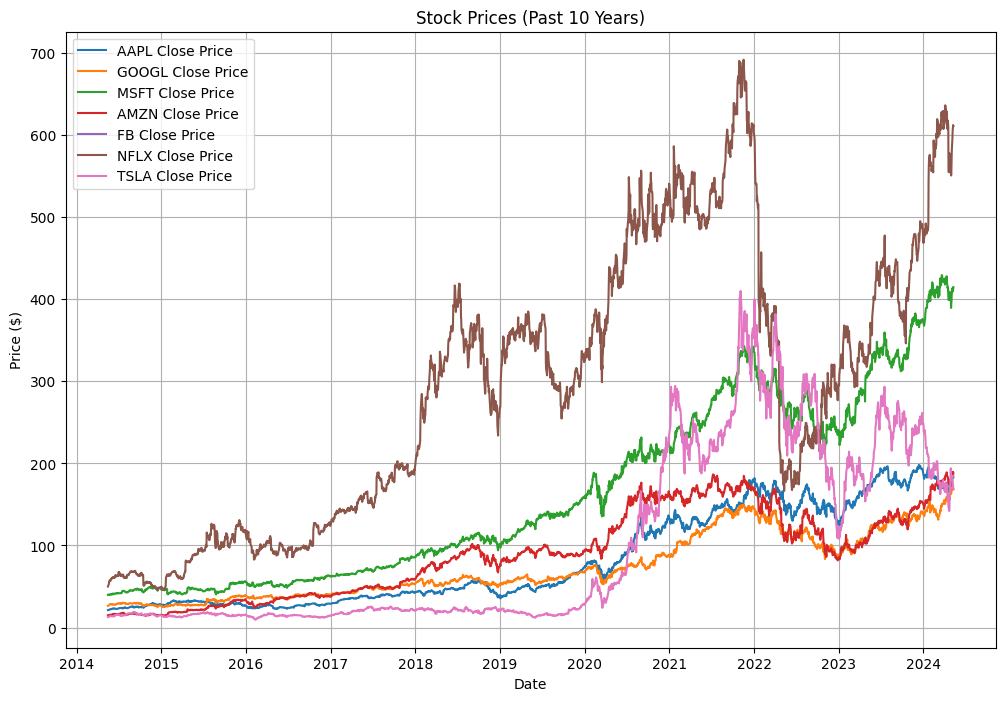

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# List of stock symbols
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB', 'NFLX', 'TSLA']

# Calculate start date (10 years ago from current date)
start_date = (datetime.now() - timedelta(days=10*365)).strftime('%Y-%m-%d')

# Fetching stock data for each symbol
stock_data = {}
for symbol in stocks:
    stock_data[symbol] = yf.download(symbol, start=start_date, end=datetime.now().strftime('%Y-%m-%d'))

# Plotting stock data
plt.figure(figsize=(12, 8))
for symbol, data in stock_data.items():
    plt.plot(data['Close'], label=f'{symbol} Close Price')

plt.title('Stock Prices (Past 10 Years)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define Berry Cox price momentum factors
factors = {
    "Price Leading 12 Month Earnings (Weighted Avg of FVI and FY2)": lambda p: p["Close"].rolling(12).mean(),
    "Log of Market Capitalization": lambda p: np.log(p.filter(like='Cap').iloc[:, 0]),
    "Price Trailing 12 Month Sales": lambda p: p["Close"] / p["SalesTTM"],
    "Log of Stock Price": lambda p: np.log(p["Close"]),
    "Price Trailing 12 Month Cash Flow": lambda p: p["Close"] / p["FreeCashFlowTTM"],
    "Price Book Value": lambda p: p["Close"] / p["BookValue"],
    "Leading Dividend Yield": lambda p: p["DividendYield"],
    "Industry Relative Price/Trailing Sales (Current Spread vs. 5 Year Avg)": lambda p: (
        p["Close"] / p["SalesTTM"] - p["Close"].rolling(60).mean()
    ),
    "Accelerating 3 Month Momentum in Quarterly Sales": lambda p: (
        p["Sales"].rolling(3).mean() / p["Sales"].rolling(6).mean()
    ),
    # Add other factors as needed...
}

# Define ETF and historical data period
etf_symbol = "SPY"
start_date = datetime(2018, 1, 1)  # 5-year backtesting period
end_date = datetime.today()

# Download ETF data
data = yf.download(etf_symbol, start=start_date, end=end_date)

# Plot ETF data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='ETF (SPY) Close Price', color='blue')
plt.title('ETF (SPY) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate slopes for each factor
slopes = {}
for factor_name, factor_func in factors.items():
    factor_values = factor_func(data)
    factor_values.dropna(inplace=True)  # Drop rows with NaN values
    if factor_values.empty:
        print(f"No data available for {factor_name}. Skipping...")
        continue
    x = np.arange(len(factor_values)).reshape(-1, 1)
    y = factor_values.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    slopes[factor_name] = slope

    # Plot factor values
    plt.figure(figsize=(12, 6))
    plt.plot(factor_values.index, factor_values, label=f'{factor_name} Value', color='green')
    plt.title(f'{factor_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot slope
    plt.figure(figsize=(6, 4))
    plt.barh(factor_name, slope, color='orange')
    plt.title(f'Slope of {factor_name}')
    plt.xlabel('Slope')
    plt.ylabel('Factor')
    plt.grid(True)
    plt.show()

# Print slopes
print("Slopes for each factor:")
for factor_name, slope in slopes.items():
    print(f"{factor_name}: {slope}")
